In [1]:
from typing import Tuple, Dict
import scipy
import numpy as np
import math
from astropy.io.fits import open, getdata
from mflex.plot.plot_magnetogram import plot_magnetogram_boundary
from mflex.classes.clsmod import Data3D, DataBz
from mflex.load.read_file import read_fits_soar
from mflex.model.field.bfield_model import magnetic_field
import numpy as np
import matplotlib.pyplot as plt
from mflex.model.plasma_parameters import deltapres, deltaden
from mflex.plot.plot_magnetogram import plot_fieldlines_soar
import matplotlib.pyplot as plt
from mflex.model.plasma_parameters import (
    bpressure,
    bdensity,
    btemp,
    deltapres,
    deltaden,
)
from datetime import datetime



Filename: /Users/lilli/Desktop/mflex/science/phi/L2/2023/solo_L2_phi-hrt-blos_20220303T101609_V01.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     623   (2048, 2048)   float32   
  1  PHI-RAW-META-DATA    1 ImageHDU        10   (8515,)   uint8   
  2  PHI_FITS_ACCU_settings    1 TableHDU        52   1R x 10C   [A19, A12, I10, I3, I3, I3, I3, I3, I10, I10]   
  3  PHI_FITS_FG_settings    1 TableHDU        40   35R x 7C   [A19, A11, I6, I10, I11, I11, I11]   
  4  PHI_FITS_FPA_settings    1 TableHDU        56   120R x 11C   [A19, A24, A12, I5, I5, I5, I5, I10, I10, I10, F15.6]   
  5  PHI_FITS_PMP_settings    1 TableHDU        44   120R x 8C   [A19, A12, I3, I5, I5, I3, I5, I5]   
  6  PHI_FITS_PROC_block    1 TableHDU        68   4R x 14C   [A19, A13, I4, I5, I10, I11, I11, I3, I3, I5, I5, I5, I5, I5]   
  7  PHI_FITS_PROC_environment    1 TableHDU        76   1R x 16C   [A19, A13, I10, I10, I10, I10, I10, I11, I11, I11, I11, I11, I1

Locator attempting to generate 1002 ticks ([-1689.0, ..., 1314.0]), which exceeds Locator.MAXTICKS (1000).


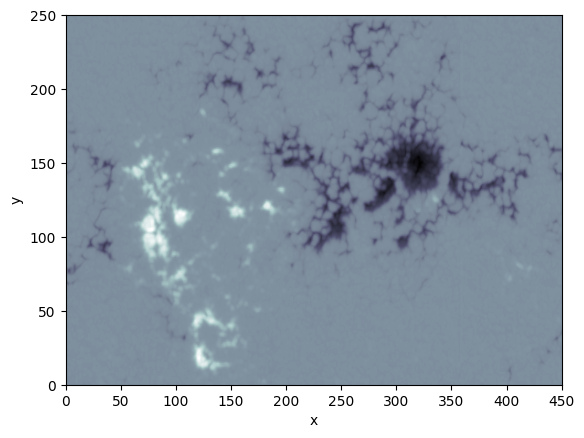

xmax, ymax, zmax 89.10000000000001 49.5 20.0
xmax_Mm, ymax_Mm, zmax_Mm 89.10000000000001 49.5 20.0
nresol_x, nresol_y, nresol_z 450 250 222
pixelsize_x, pixelsize_x_Mm 0.198 0.198
pixelsize_y, pixelsize_y_Mm 0.198 0.198
pixelsize_z, pixelsize_z_Mm 0.198 0.198


In [2]:
path = (
    "/Users/lilli/Desktop/mflex/science/phi/L2/2023/solo_L2_phi-hrt-blos_20220303T101609_V01.fits"
)

header = True
L = 1.0
with open(path) as data:
        data.info()
        image = getdata(path, ext=False)
        x_len = image.shape[0]
        y_len = image.shape[1]
        #plot_magnetogram_boundary(image, x_len, y_len)
        x_start = 1250
        x_last = 1700
        y_start = 1150
        y_last = 1400
        cut_image = image[y_start:y_last, x_start:x_last]
        plot_magnetogram_boundary(cut_image, x_last - x_start, y_last - y_start)
        hdr = data[0].header  # the primary HDU header
        dist = hdr["DSUN_OBS"]
        pixelsize_x_unit = hdr["CUNIT1"]
        pixelsize_y_unit = hdr["CUNIT2"]
        pixelsize_x_arcsec = hdr["CDELT1"]
        pixelsize_y_arcsec = hdr["CDELT2"]

        if not pixelsize_x_unit == pixelsize_y_unit:
            print("Pixelsize units not matchy-matchy")
            raise ValueError
        if not pixelsize_x_arcsec == pixelsize_y_arcsec:
            print("Data pixelsizes in x and y direction not matchy-matchy")
            raise ValueError
        else:
            pixelsize_radians = pixelsize_x_arcsec / 206265.0

dist_km = dist / 1000.0
pixelsize_Mm = np.floor(pixelsize_radians * dist_km) * 10**-3

nresol_x = cut_image.shape[1]
nresol_y = cut_image.shape[0]

xmax_Mm = nresol_x * pixelsize_Mm
ymax_Mm = nresol_y * pixelsize_Mm
pixelsize_z_Mm = 90.0 * 10**-3

zmax_Mm = 20000.0 * 10**-3

xmin = 0.0  # Minimum value of x in data length scale, not in Mm
ymin = 0.0  # Minimum value of y in data length scale, not in Mm
zmin = 0.0  # Minimum value of z in data length scale, not in Mm

nresol_z = int(np.floor(zmax_Mm / pixelsize_z_Mm))

z0 = 2000.0 * 10**-3

nf_max = min(nresol_x, nresol_y)

xmax = xmax_Mm / L
ymax = ymax_Mm / L
zmax = zmax_Mm / L
z0 = z0 / L

pixelsize_x = pixelsize_Mm / L
pixelsize_y = pixelsize_Mm / L
pixelsize_z = pixelsize_Mm / L
print("xmax, ymax, zmax", xmax, ymax, zmax)
print("xmax_Mm, ymax_Mm, zmax_Mm", xmax_Mm, ymax_Mm, zmax_Mm)
print("nresol_x, nresol_y, nresol_z", nresol_x, nresol_y, nresol_z)
print("pixelsize_x, pixelsize_x_Mm", pixelsize_x, pixelsize_Mm)
print("pixelsize_y, pixelsize_y_Mm", pixelsize_y, pixelsize_Mm)
print("pixelsize_z, pixelsize_z_Mm", pixelsize_z, pixelsize_Mm)

data = DataBz(
    cut_image,
    nresol_x,
    nresol_y,
    nresol_z,
    pixelsize_x,
    pixelsize_y,
    pixelsize_z,
    nf_max,
    xmin,
    xmax,
    ymin,
    ymax,
    zmin,
    zmax,
    z0,
)

data_bz = data.data_z
# data_by: np.ndarray[np.float64, np.dtype[np.float64]] = data.data_y
# data_bx: np.ndarray[np.float64, np.dtype[np.float64]] = data.data_x
nresol_x = data.nresol_x
nresol_y = data.nresol_y
nresol_z = data.nresol_z
pixelsize_x = data.pixelsize_x
pixelsize_y = data.pixelsize_y
pixelsize_z = data.pixelsize_z
nf_max = data.nf_max
xmin = data.xmin
xmax = data.xmax
ymin = data.ymin
ymax = data.ymax
zmin = data.zmin
zmax = data.zmax
z0 = data.z0

a = 0.3
alpha = 0.01
b = 1.0

deltaz = z0 / 10.0


In [3]:
z0_b = z0
deltaz_b = deltaz 

bfield, dpartial_bfield = magnetic_field(
    data_bz,
    z0_b,
    deltaz_b,
    a,
    b,
    alpha,
    xmin,
    xmax,
    ymin,
    ymax,
    zmin,
    zmax,
    nresol_x,
    nresol_y,
    nresol_z,
    pixelsize_x,
    pixelsize_y,
    nf_max,
    L
)

length scale 2.0
length scale x 178.20000000000002
length scale y 99.0
length scale x norm 89.10000000000001
length scale y norm 49.5
xmin, xmax, ymin, ymax, zmin, zmax  0.0 89.10000000000001 0.0 49.5 0.0 20.0


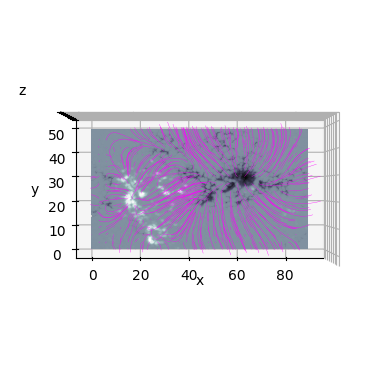

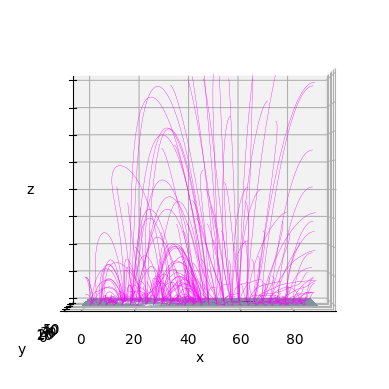

In [4]:
h1 = L / 100.0 # Initial step length for fieldline3D
eps = 1.0e-8
# Tolerance to which we require point on field line known for fieldline3D
hmin = 0.0  # Minimum step length for fieldline3D
hmax = L # Maximum step length for fieldline3D

plot_fieldlines_soar(
    bfield,
    h1,
    hmin,
    hmax,
    eps,
    nresol_x,
    nresol_y,
    nresol_z,
    -xmax,
    xmax,
    -ymax,
    ymax,
    zmin,
    zmax,
    a,
    b,
    alpha,
    stepsize=3.0,
    view = "top",
)

plot_fieldlines_soar(
    bfield,
    h1,
    hmin,
    hmax,
    eps,
    nresol_x,
    nresol_y,
    nresol_z,
    -xmax,
    xmax,
    -ymax,
    ymax,
    zmin,
    zmax,
    a,
    b,
    alpha,
    stepsize=3.0,
    view = "side",
)